In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_error, precision_score, recall_score, r2_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import optuna

# Регрессия

In [2]:
RAW_FEATS = 'regression_raw_feats.csv'
RAW_TARGET = 'regression_raw_target.csv'
PROCESSED_FEATS = 'regression_processed_feats.csv'
PROCESSED_TARGET = 'regression_processed_target.csv'

In [3]:
df_feats_raw = pd.read_csv(RAW_FEATS)
df_target_raw = pd.read_csv(RAW_TARGET)
df_feats_processed = pd.read_csv(PROCESSED_FEATS)
df_target_processed = pd.read_csv(PROCESSED_TARGET)

In [4]:
def evaluate(metrics, y_test, y_pred, round_num):
    for metric in metrics:
        print(f'Model score for metric "{metric.__name__}": {round(metric(y_test, y_pred), round_num)}')

    plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
    line_coords = np.linspace(np.min(y_test), np.max(y_test), 100)
    plt.plot(line_coords, line_coords, color='red', linestyle='--', linewidth=2, label='Perfect prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title('Actual vs predicted values')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
eval_metrics = [mean_absolute_error, root_mean_squared_error, r2_score]
random_state = 42
test_size = 0.2

round_num = 4

optuna_metric = root_mean_squared_error
optuna_direction = "minimize"
n_trials = 30
cv = 5

## Готовая модель

In [6]:
model_class = ElasticNet

### Бейзлайн

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [8]:
model = model_class()

model.fit(X_train, y_train)

ElasticNet()

In [9]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.6957
Model score for metric "root_mean_squared_error": 4.7121
Model score for metric "r2_score": 0.4931


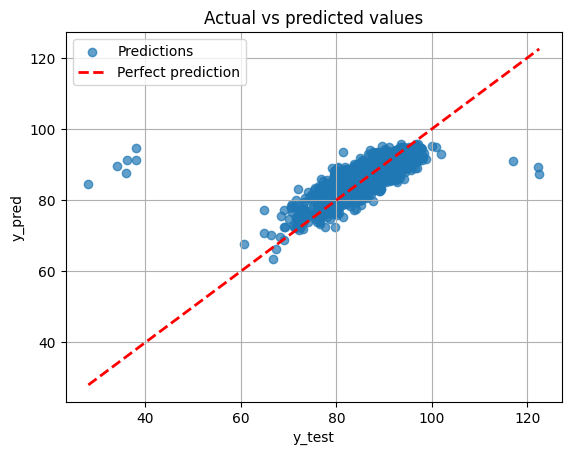

In [10]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [12]:
model = model_class()

model.fit(X_train, y_train)

ElasticNet()

In [13]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.9439
Model score for metric "root_mean_squared_error": 3.9996
Model score for metric "r2_score": 0.499


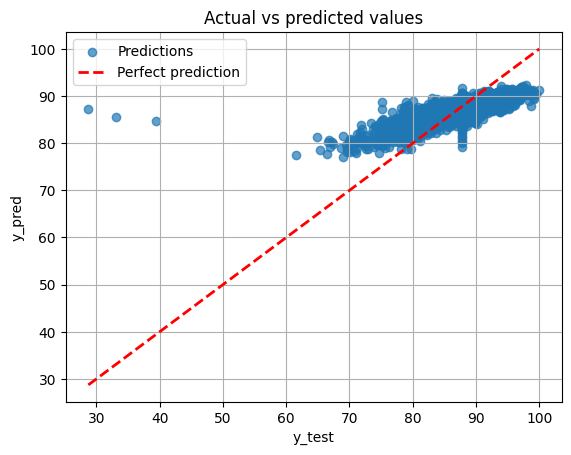

In [14]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [15]:
def objective(trial):
    optuna_params = {
        'alpha': trial.suggest_float('alpha', 0.0, 1.0),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'tol': trial.suggest_float('tol', 1e-5, 1e-3),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-08 22:52:39,931] A new study created in memory with name: no-name-4e6e88d7-9c8d-4b95-ae08-57c6dd23197e
[I 2025-12-08 22:52:41,379] Trial 0 finished with value: 4.485771924274385 and parameters: {'alpha': 0.3745401188473625, 'l1_ratio': 0.9507143064099162, 'max_iter': 3928, 'tol': 0.0006026718993550663}. Best is trial 0 with value: 4.485771924274385.
[I 2025-12-08 22:52:42,374] Trial 1 finished with value: 4.394423356210999 and parameters: {'alpha': 0.15601864044243652, 'l1_ratio': 0.15599452033620265, 'max_iter': 1232, 'tol': 0.0008675143843171858}. Best is trial 1 with value: 4.394423356210999.
[I 2025-12-08 22:52:43,284] Trial 2 finished with value: 4.62589675888964 and parameters: {'alpha': 0.6011150117432088, 'l1_ratio': 0.7080725777960455, 'max_iter': 1082, 'tol': 0.0009702107536403744}. Best is trial 1 with value: 4.394423356210999.
[I 2025-12-08 22:52:43,314] Trial 3 finished with value: 4.833513006758638 and parameters: {'alpha': 0.8324426408004217, 'l1_ratio': 0.212

Лучшие параметры для модели: {'alpha': 0.0003546890980077183, 'l1_ratio': 0.79903868834662, 'max_iter': 4612, 'tol': 0.000784906091545598}
Лучшая метрика (root_mean_squared_error): 4.3294


ElasticNet(alpha=0.0003546890980077183, l1_ratio=0.79903868834662,
           max_iter=4612, tol=0.000784906091545598)

In [16]:
y_pred = best_model.predict(X_test)

Model score for metric "mean_absolute_error": 2.195
Model score for metric "root_mean_squared_error": 3.1948
Model score for metric "r2_score": 0.6803


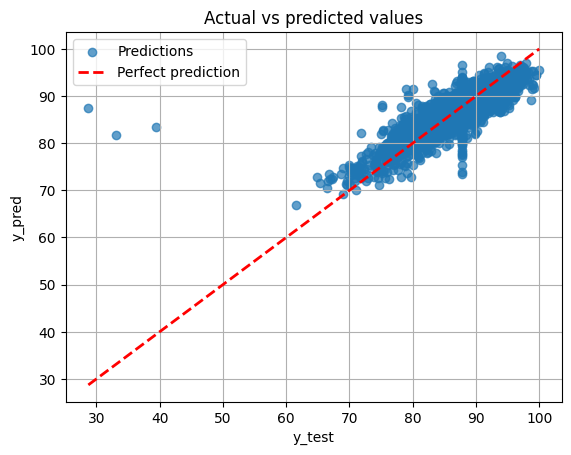

In [17]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

## Своя модель

In [18]:
class MyElasticNet:
    """
    Parameters
    -----------
    alpha : float, default=1.0
    l1_ratio : float, default=0.5
    max_iter : int, default=1000
    tol : float, default=1e-4
    """
    def __init__(self, alpha: float = 1.0, l1_ratio: float = 0.5, max_iter: int = 1000, tol: float = 1e-4):
        if alpha < 0:
            raise ValueError("alpha must be non-negative.")
        if not 0 <= l1_ratio <= 1:
            raise ValueError("l1_ratio must be between 0 and 1.")
        if max_iter <= 0:
            raise ValueError("max_iter must be a positive integer.")
        if tol <= 0:
            raise ValueError("tol must be positive.")
            
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        self.tol = tol
        
        self.coef_ = None
        self.intercept_ = None
        self._X_mean = None
        self._X_std = None
        self._y_mean = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'MyElasticNet':
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).ravel()

        self._X_mean = np.mean(X, axis=0)
        self._X_std = np.std(X, axis=0)
        self._X_std[self._X_std == 0] = 1
        X_std = (X - self._X_mean) / self._X_std

        self._y_mean = np.mean(y)
        y_centered = y - self._y_mean

        n_samples, n_features = X_std.shape

        w = np.zeros(n_features)

        for _ in range(self.max_iter):
            w_old = w.copy()
            for j in range(n_features):
                residual = y_centered - (X_std @ w) + X_std[:, j] * w[j]
                rho_j = (1 / n_samples) * np.dot(X_std[:, j], residual)

                l1_penalty = self.alpha * self.l1_ratio
                if rho_j < -l1_penalty:
                    w_j_update = rho_j + l1_penalty
                elif rho_j > l1_penalty:
                    w_j_update = rho_j - l1_penalty
                else:
                    w_j_update = 0

                l2_penalty = self.alpha * (1 - self.l1_ratio)
                w[j] = w_j_update / (1 + l2_penalty)
            
            if np.linalg.norm(w - w_old) < self.tol:
                break

        self.coef_ = w / self._X_std
        self.intercept_ = self._y_mean - np.dot(self._X_mean, self.coef_)
        
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.coef_ is None:
            raise RuntimeError("You must call fit() before predict().")
        X = np.asarray(X, dtype=float)
        return np.dot(X, self.coef_) + self.intercept_

    def get_params(self, deep: bool = True) -> dict:
        return {
            'alpha': self.alpha,
            'l1_ratio': self.l1_ratio,
            'max_iter': self.max_iter,
            'tol': self.tol,
        }

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter {key} for MyElasticNet")
        return self

In [19]:
model_class = MyElasticNet

### Бейзлайн

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [21]:
model = model_class()

model.fit(X_train, y_train)

In [22]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.9616
Model score for metric "root_mean_squared_error": 4.9309
Model score for metric "r2_score": 0.445


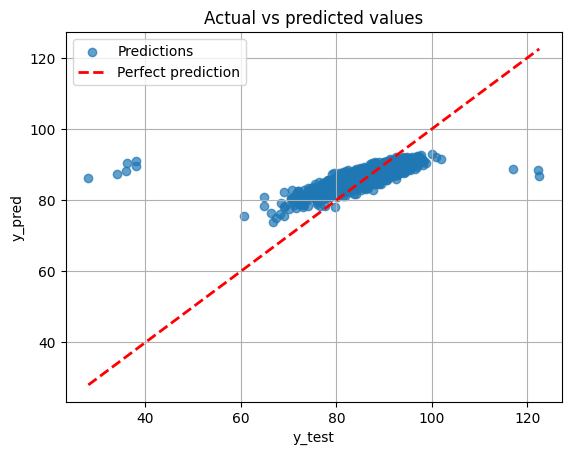

In [23]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Вывод: mae и mse совпадают с точностью до целых, r2 хуже. Судя по всему, модель не успела обучиться.

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [25]:
model = model_class()

model.fit(X_train, y_train)

In [26]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.9091
Model score for metric "root_mean_squared_error": 3.9549
Model score for metric "r2_score": 0.5101


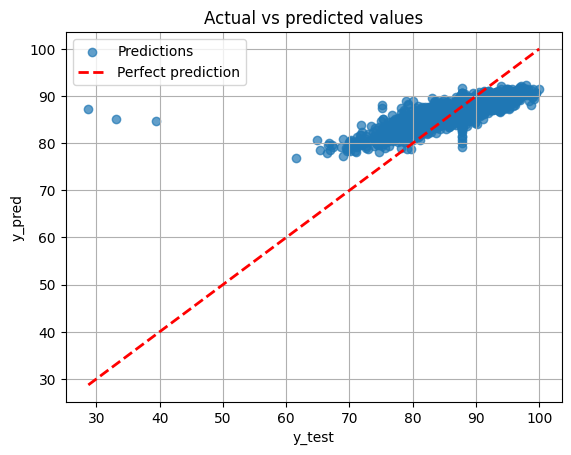

In [27]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Вывод: результат приблизительно как у библиотечной модели. Видно, что модель не успела обучиться.

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [28]:
def objective(trial):
    optuna_params = {
        'alpha': trial.suggest_float('alpha', 0.0, 1.0),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'tol': trial.suggest_float('tol', 1e-5, 1e-3),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-08 22:52:44,834] A new study created in memory with name: no-name-9797f1ae-b131-4e03-8c6c-0526afca3656
[I 2025-12-08 22:52:44,871] Trial 0 finished with value: 4.4177008023943545 and parameters: {'alpha': 0.3745401188473625, 'l1_ratio': 0.9507143064099162, 'max_iter': 3928, 'tol': 0.0006026718993550663}. Best is trial 0 with value: 4.4177008023943545.
[I 2025-12-08 22:52:44,903] Trial 1 finished with value: 4.36927246049113 and parameters: {'alpha': 0.15601864044243652, 'l1_ratio': 0.15599452033620265, 'max_iter': 1232, 'tol': 0.0008675143843171858}. Best is trial 1 with value: 4.36927246049113.
[I 2025-12-08 22:52:44,935] Trial 2 finished with value: 4.572152601702635 and parameters: {'alpha': 0.6011150117432088, 'l1_ratio': 0.7080725777960455, 'max_iter': 1082, 'tol': 0.0009702107536403744}. Best is trial 1 with value: 4.36927246049113.
[I 2025-12-08 22:52:44,966] Trial 3 finished with value: 4.787590530786359 and parameters: {'alpha': 0.8324426408004217, 'l1_ratio': 0.212

Лучшие параметры для модели: {'alpha': 0.0003546890980077183, 'l1_ratio': 0.79903868834662, 'max_iter': 4612, 'tol': 0.000784906091545598}
Лучшая метрика (root_mean_squared_error): 4.3294


In [29]:
y_pred = best_model.predict(X_test)

Model score for metric "mean_absolute_error": 2.1949
Model score for metric "root_mean_squared_error": 3.1948
Model score for metric "r2_score": 0.6803


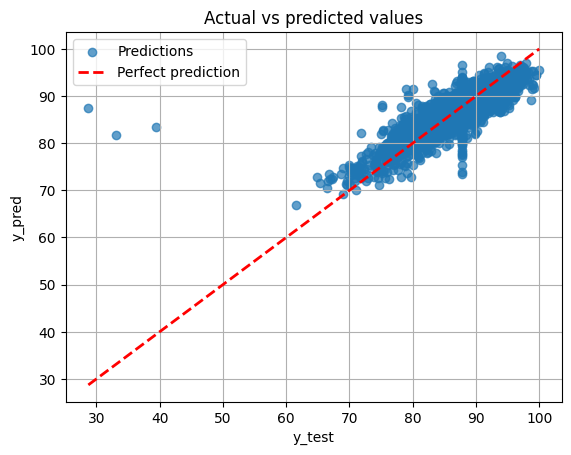

In [30]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Вывод: результат почти равен библиотечной модели, с точностью до 1е-4!

# Классификация

In [31]:
RAW_FEATS = 'classification_raw_feats.csv'
RAW_TARGET = 'classification_raw_target.csv'
PROCESSED_FEATS = 'classification_processed_feats.csv'
PROCESSED_TARGET = 'classification_processed_target.csv'

In [32]:
df_feats_raw = pd.read_csv(RAW_FEATS)
df_target_raw = pd.read_csv(RAW_TARGET)
df_feats_processed = pd.read_csv(PROCESSED_FEATS)
df_target_processed = pd.read_csv(PROCESSED_TARGET)

In [33]:
def evaluate(y_test, y_pred_class, y_pred_proba, round_num):

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

    print(f"ROC AUC: {round(roc_auc,round_num)}", '\n')

    f1 = f1_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)

    print(f"Precision: {round(precision,round_num)}")
    print(f"Recall: {round(recall,round_num)}")
    print(f"F1-Score: {round(f1,round_num)}")

    plt.plot(fpr, tpr, label=f'ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt = 'd', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion matrix')
    plt.show()

In [34]:
eval_metrics = [f1_score, roc_auc_score]
random_state = 42
test_size = 0.2

round_num = 4

optuna_metric = f1_score
optuna_direction = "maximize"
n_trials = 20
cv = 5

## Готовая модель

In [35]:
model_class = LogisticRegression

### Бейзлайн

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [37]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [38]:
model = model_class(solver='liblinear')

model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [39]:
y_pred_class = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.8426 

Precision: 0.8803
Recall: 0.2548
F1-Score: 0.3952


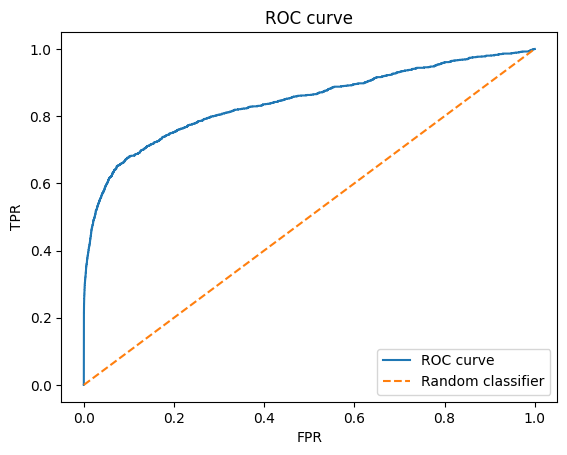

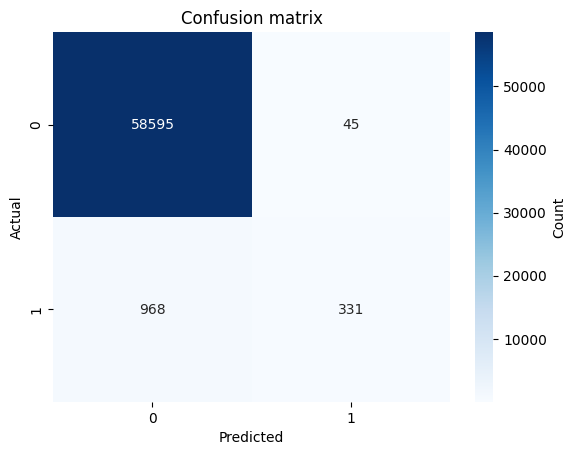

In [40]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [42]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [43]:
model = model_class(solver='liblinear')

model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [44]:
y_pred_class = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9524 

Precision: 0.8068
Recall: 0.4596
F1-Score: 0.5856


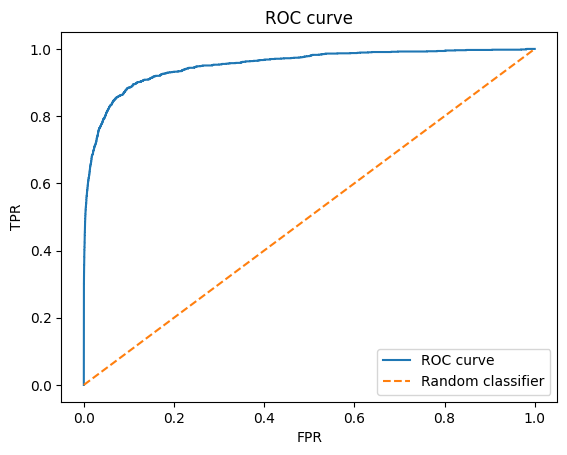

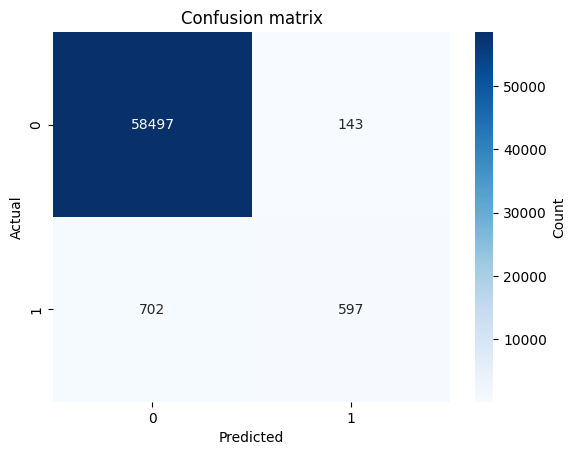

In [45]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [46]:
def objective(trial):
    optuna_params = {
        'solver': trial.suggest_categorical('solver', ['liblinear']),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 0.1, 10.0),
        'max_iter': trial.suggest_int('max_iter', 100, 2000),
        'C': trial.suggest_float('C', 1e-4, 1e4),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'tol': trial.suggest_float('tol', 1e-5, 1e-3),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-08 22:52:49,553] A new study created in memory with name: no-name-69bbe7d5-b440-462f-920d-2884e6d369df
[I 2025-12-08 22:52:50,476] Trial 0 finished with value: 0.5486080214954976 and parameters: {'solver': 'liblinear', 'fit_intercept': False, 'intercept_scaling': 7.34674002393291, 'max_iter': 1238, 'C': 1560.1864888225011, 'penalty': 'l1', 'tol': 0.0008675143843171858}. Best is trial 0 with value: 0.5486080214954976.
[I 2025-12-08 22:52:51,553] Trial 1 finished with value: 0.5490115087402506 and parameters: {'solver': 'liblinear', 'fit_intercept': False, 'intercept_scaling': 0.3037864935284442, 'max_iter': 1943, 'C': 8324.426424759953, 'penalty': 'l1', 'tol': 0.00019157046475489948}. Best is trial 1 with value: 0.5490115087402506.
[I 2025-12-08 22:52:52,437] Trial 2 finished with value: 0.5490115087402506 and parameters: {'solver': 'liblinear', 'fit_intercept': False, 'intercept_scaling': 4.376255684556946, 'max_iter': 653, 'C': 6118.5289860385055, 'penalty': 'l2', 'tol': 0.

Лучшие параметры для модели: {'solver': 'liblinear', 'fit_intercept': True, 'intercept_scaling': 7.694534641062876, 'max_iter': 183, 'C': 7661.630609661064, 'penalty': 'l1', 'tol': 0.0007033827383029576}
Лучшая метрика (f1_score): 0.5941


LogisticRegression(C=7661.630609661064, intercept_scaling=7.694534641062876,
                   max_iter=183, penalty='l1', solver='liblinear',
                   tol=0.0007033827383029576)

In [47]:
y_pred_class = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

ROC AUC: 0.9523 

Precision: 0.8078
Recall: 0.4596
F1-Score: 0.5859


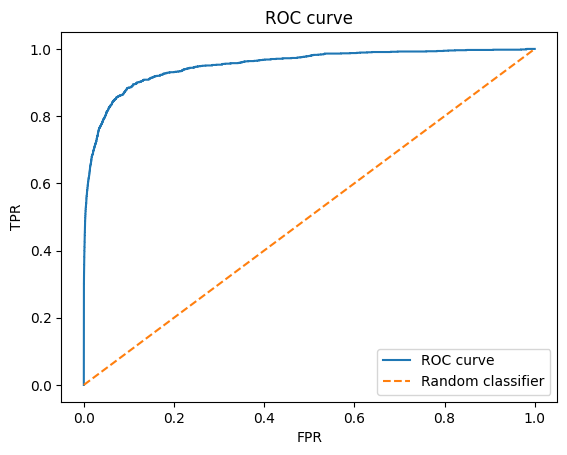

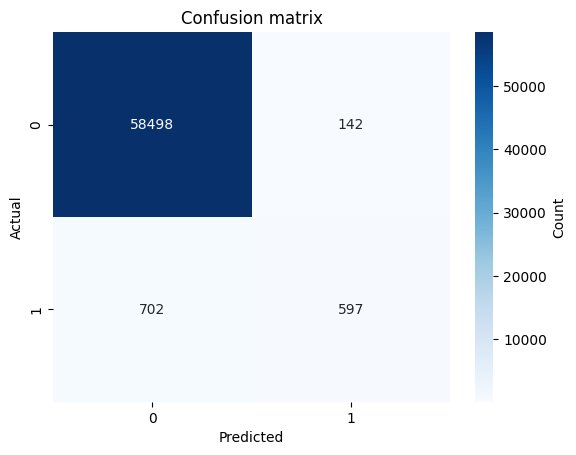

In [48]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

## Своя модель

In [49]:
class MyLogisticRegression:
    """
    Parameters
    -----------
    fit_intercept : bool, default=True
    intercept_scaling : float, default=1.0
    max_iter : int, default=1000
    C : float, default=1.0
    penalty : {'l1', 'l2'}, default='l2'
    tol : float, default=1e-4
    threshold : float, devault = 0.5
    """
    def __init__(self, fit_intercept: bool = True, intercept_scaling: float = 1.0,
                 max_iter: int = 1000, C: float = 1.0, penalty: str = 'l2',
                 tol: float = 1e-4, threshold: float = 0.5):
        if not isinstance(fit_intercept, bool):
            raise ValueError("fit_intercept must be a boolean.")
        if intercept_scaling <= 0:
            raise ValueError("intercept_scaling must be a positive float.")
        if max_iter <= 0:
            raise ValueError("max_iter must be a positive integer.")
        if C <= 0:
            raise ValueError("C must be a positive float.")
        if penalty not in ['l1', 'l2']:
            raise ValueError("penalty must be 'l1' or 'l2'.")
        if tol <= 0:
            raise ValueError("tol must be a positive float.")

        self.fit_intercept = fit_intercept
        self.intercept_scaling = intercept_scaling
        self.max_iter = max_iter
        self.C = C
        self.penalty = penalty
        self.tol = tol
        self.threshold = threshold

        self.coef_ = None
        self.intercept_ = 0.0
        self._X_mean = None
        self._X_std = None
        self._n_features = None

    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'MyLogisticRegression':
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).ravel()

        if X.shape[0] != y.shape[0]:
            raise ValueError("Number of samples in X and y must be equal.")

        n_samples, self._n_features = X.shape

        self._X_mean = np.mean(X, axis=0)
        self._X_std = np.std(X, axis=0)
        self._X_std[self._X_std == 0] = 1
        X_std = (X - self._X_mean) / self._X_std

        if self.fit_intercept:
            synthetic_feature = np.full((n_samples, 1), self.intercept_scaling)
            X_std = np.hstack([X_std, synthetic_feature])

        w = np.zeros(X_std.shape[1])
        lambda_ = 1.0 / self.C

        for _ in range(self.max_iter):
            w_old = w.copy()
            
            for j in range(len(w)):
                z = X_std @ w
                p = self._sigmoid(z)
                residuals = p - y
                
                grad_j = (1 / n_samples) * np.dot(X_std[:, j], residuals)

                w_j_approx = w[j] - grad_j

                if self.penalty == 'l1':
                    if w_j_approx > 0:
                        w[j] = max(0, w_j_approx - lambda_)
                    else:
                        w[j] = min(0, w_j_approx + lambda_)
                elif self.penalty == 'l2':
                    w[j] = w_j_approx / (1 + lambda_)
            
            if np.sum(np.abs(w - w_old)) < self.tol:
                break

        if self.fit_intercept:
            self.coef_ = w[:-1] / self._X_std
            self.intercept_ = w[-1] * self.intercept_scaling
            self.intercept_ -= np.dot(self._X_mean, self.coef_)
        else:
            self.coef_ = w / self._X_std
            self.intercept_ = 0.0

        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if self.coef_ is None:
            raise RuntimeError("You must call fit() before predict_proba().")
        X = np.asarray(X, dtype=float)
        
        z = X @ self.coef_ + self.intercept_
        proba_1 = self._sigmoid(z)
        
        proba_0 = 1 - proba_1
        return np.vstack([proba_0, proba_1]).T

    def predict(self, X: np.ndarray) -> np.ndarray:
        proba = self.predict_proba(X)
        return (proba[:, 1] >= self.threshold).astype(int)

    def get_params(self, deep: bool = True) -> dict:
        return {
            'fit_intercept': self.fit_intercept,
            'intercept_scaling': self.intercept_scaling,
            'max_iter': self.max_iter,
            'C': self.C,
            'penalty': self.penalty,
            'tol': self.tol,
        }

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter {key} for MyLogisticRegression")
        return self

In [50]:
model_class = MyLogisticRegression

### Бейзлайн

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [52]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [53]:
model = model_class()

model.fit(X_train, y_train)

In [54]:
y_pred_class = model.predict(X_test)

In [55]:
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9279 

Precision: 0.901
Recall: 0.0701
F1-Score: 0.13


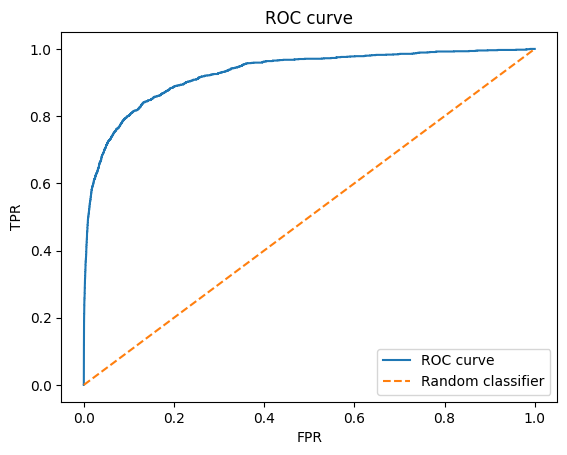

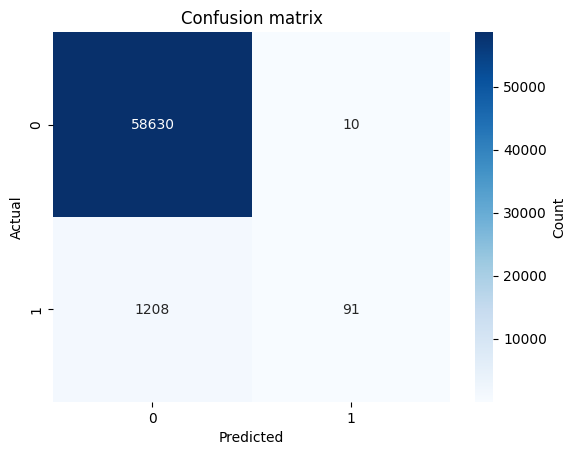

In [56]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

Высокий ROC-AUC, но F1 сильно хуже в сравнении с библиотечной моделью.

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [58]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [59]:
model = model_class()

model.fit(X_train, y_train)

In [60]:
y_pred_class = model.predict(X_test)

In [61]:
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9437 

Precision: 0.9329
Recall: 0.2248
F1-Score: 0.3623


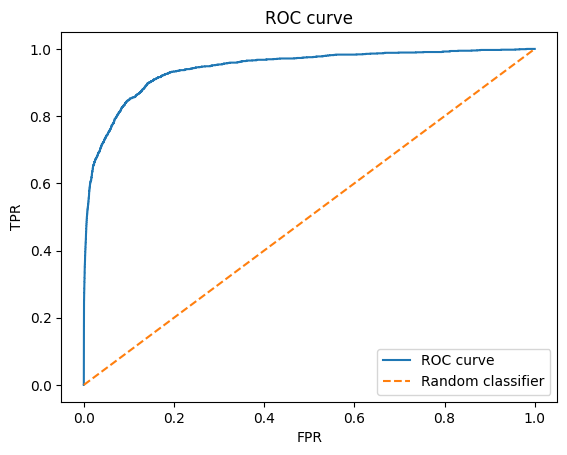

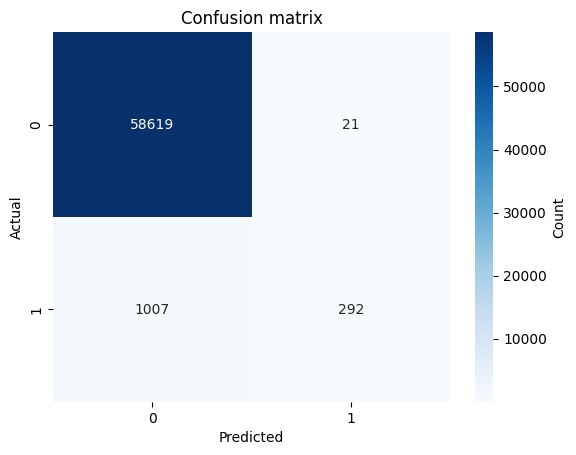

In [62]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

F1 улучшился, но всё ещё сильно хуже чем у библиотечной модели.

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [63]:
def objective(trial):
    optuna_params = {
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 0.1, 10.0),
        'max_iter': trial.suggest_int('max_iter', 100, 2000),
        'C': trial.suggest_float('C', 1e-4, 1e4),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'tol': trial.suggest_float('tol', 1e-5, 1e-3),
        'threshold': trial.suggest_float('threshold', 0.0, 1.0),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-08 22:53:54,307] A new study created in memory with name: no-name-ce692a35-034f-4a84-8854-d2369b2606eb
[I 2025-12-08 22:54:01,860] Trial 0 finished with value: 0.130828083057096 and parameters: {'fit_intercept': False, 'intercept_scaling': 7.34674002393291, 'max_iter': 1238, 'C': 1560.1864888225011, 'penalty': 'l1', 'tol': 0.0008675143843171858, 'threshold': 0.6011150117432088}. Best is trial 0 with value: 0.130828083057096.
[I 2025-12-08 22:55:33,797] Trial 1 finished with value: 0.5882427611958314 and parameters: {'fit_intercept': True, 'intercept_scaling': 9.702107536403744, 'max_iter': 1682, 'C': 2123.391185548851, 'penalty': 'l2', 'tol': 0.00031119982052994234, 'threshold': 0.5247564316322378}. Best is trial 1 with value: 0.5882427611958314.
[I 2025-12-08 22:56:21,731] Trial 2 finished with value: 0.586372793773914 and parameters: {'fit_intercept': True, 'intercept_scaling': 6.157343657751556, 'max_iter': 365, 'C': 2921.446556137717, 'penalty': 'l2', 'tol': 0.0007873242

Лучшие параметры для модели: {'fit_intercept': True, 'intercept_scaling': 3.43042135257933, 'max_iter': 1508, 'C': 9671.941753107718, 'penalty': 'l2', 'tol': 0.00036472262450446864, 'threshold': 0.3739777057415845}
Лучшая метрика (f1_score): 0.5914


In [64]:
y_pred_class = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

ROC AUC: 0.9525 

Precision: 0.7437
Recall: 0.5204
F1-Score: 0.6123


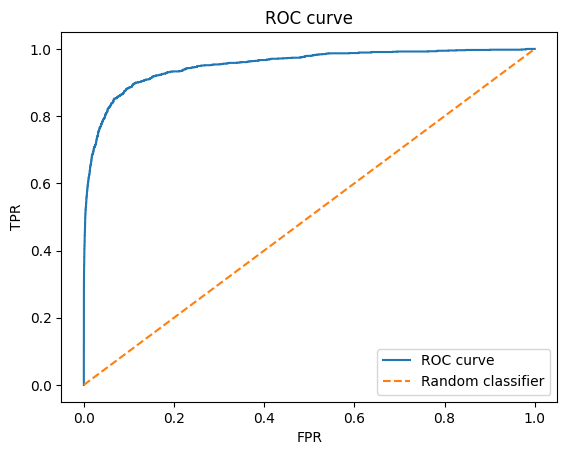

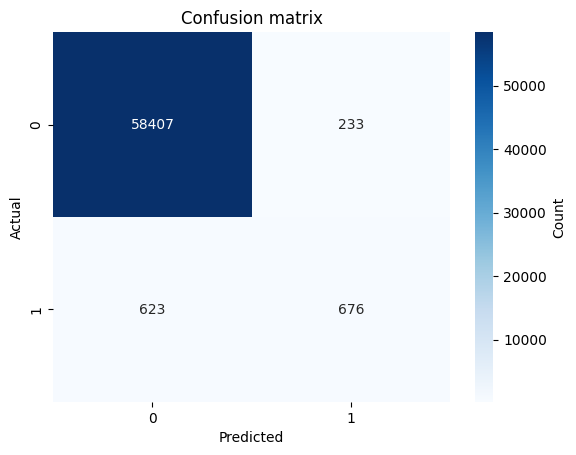

In [65]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

По метрикам получилось даже немного лучше чем библиотечная модель.

# Выводы

После тюнинга с Optuna кастомные версии ElasticNet и LinerRegression показали сравнимые с оригинальными моделями результаты. В LinearRegression использовался solver liblinear как референс.